In [1]:
import os
while os.getcwd()[-len('mcrc-cetuximab-analysis'):] != 'mcrc-cetuximab-analysis':
    os.chdir('..')
os.getcwd() 

'/home/max/mcrc-cetuximab-analysis'

In [2]:
import numpy as np
import pickle as pkl
import pandas as pd

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

import decoupler

/home/max/mcrc-cetuximab-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/max/mcrc-cetuximab-analysis/.venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
counts = pd.read_csv('data/raw_counts_hgnc_filtered_by_ann.csv', index_col=0)
ann = pd.read_csv('data/ann.csv', index_col=0).rename(columns={'treatment response': 'treatment_response'})

In [6]:
def filter_counts(counts):
    return counts.loc[:,counts.max() > 10].astype(int)

In [7]:
pre_ann = ann[(ann['time point'] == 'pre-treatment') & (ann['treatment_response'] != 'unknown')]
post_ann = ann[ann['time point'] == 'post-treatment']
pre_counts = filter_counts(counts.loc[pre_ann.index])
post_counts = filter_counts(counts.loc[post_ann.index])
len(pre_ann), len(post_ann), pre_counts.shape, post_counts.shape 

(25, 13, (25, 17709), (13, 17375))

In [8]:
for counts, ann, prefix in [(pre_counts, pre_ann, 'pre'), (post_counts, post_ann, 'post')]:
    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
        counts=counts,
        metadata=ann,
        design="~treatment_response",
        refit_cooks=True,
        inference=inference,
        n_cpus=8, # n_cpus can be specified here or in the inference object
    )
    
    dds.deseq2()
    
    with open(os.path.join('results', f"dds_{prefix}.pkl"), "wb") as f:
        pkl.dump(dds, f)
        

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 38.10 seconds.

Fitting dispersion trend curve...
... done in 3.38 seconds.

Fitting MAP dispersions...
... done in 45.25 seconds.

Fitting LFCs...
... done in 5.23 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 1012 outlier genes.

Fitting dispersions...
... done in 1.54 seconds.

Fitting MAP dispersions...
... done in 1.25 seconds.

Fitting LFCs...
... done in 0.38 seconds.

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 35.73 seconds.

Fitting dispersion trend curve...
... done in 3.11 seconds.

Fitting MAP dispersions...
... done in 39.47 seconds.

Fitting LFCs...
... done in 4.74 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 608 outlier genes.

Fitting dispersions...
... done in 0.97 seconds.

Fitting MAP dispersions...
... done in 1.12 seconds.

Fitting LFCs...
... done in 0.49 seconds.



In [9]:
prefix = 'pre'
with open(os.path.join('results', f"dds_{prefix}.pkl"), "rb") as f:
    dds = pkl.load(f)

print((~np.isfinite(pd.DataFrame(dds.varm["LFC"]))).sum())

Intercept                       0
treatment_response[T.non-PD]    0
dtype: int64


In [10]:
for counts, ann, prefix in [(pre_counts, pre_ann, 'pre'), (post_counts, post_ann, 'post')]:
    with open(os.path.join('results', f"dds_{prefix}.pkl"), "rb") as f:
        dds = pkl.load(f)
    inference = DefaultInference(n_cpus=8)
    ds = DeseqStats(dds,
                    contrast=["treatment_response", "PD", "non-PD"],
                    inference=inference,
                    quiet=True)
    ds.summary(lfc_null=1, alt_hypothesis="greaterAbs")
    with open(os.path.join('results', f"ds_{prefix}.pkl"), "wb") as f:
        pkl.dump(ds, f)

In [11]:
deseq_results = dict()
for counts, ann, prefix in [(pre_counts, pre_ann, 'pre'), (post_counts, post_ann, 'post')]:
    with open(os.path.join('results', f"ds_{prefix}.pkl"), "rb") as f:
        ds = pkl.load(f)
    deseq_results[prefix] = ds.results_df

MYH13


/tmp/ipykernel_7043/2890206219.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


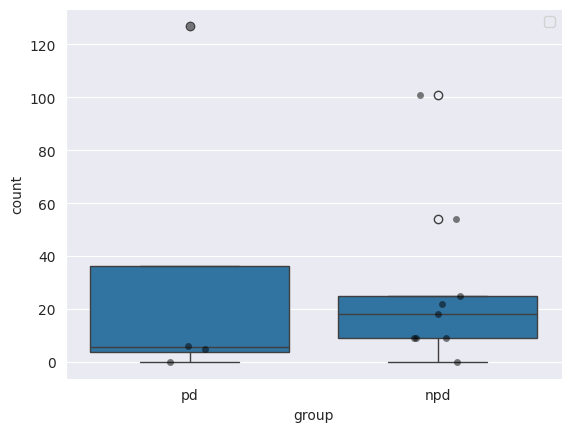

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_gene_counts_dist(counts, ann, gene):
    pd_points = counts.loc[ann[ann['treatment_response'] == 'PD'].index][gene]
    npd_points = counts.loc[ann[ann['treatment_response'] == 'non-PD'].index][gene]
    df = pd.concat([pd.DataFrame([(p, 'pd') for p in pd_points], columns=['count', 'group']),
                    pd.DataFrame([(p, 'npd') for p in npd_points], columns=['count', 'group'])])
    sns.boxplot(df, x='group', y='count')
    sns.stripplot(df, x="group", y="count", color='black', alpha=0.5, jitter=True)
    plt.legend()


group = 'post'
gene_id = 2
only_padj = False


mask_p = deseq_results[group].isna()['pvalue']
mask_padj = deseq_results[group].isna()['padj']
if only_padj:
    mask = mask_padj & (~mask_p)
else:
    mask = mask_padj

if group == 'pre':
    cts = pre_counts
    ann = pre_ann
else:
    cts = post_counts
    ann = post_ann

res = deseq_results[group]
gene = res.loc[mask].index[gene_id]
print(gene)
plot_gene_counts_dist(cts, ann, gene)

In [13]:
for group in deseq_results:
    # only nans, no inf -inf
    assert ((~np.isfinite(deseq_results[group])) & (~deseq_results[group].isna())).sum().sum() == 0 
    
    mask_p = deseq_results[group].isna()['pvalue']
    mask_padj = deseq_results[group].isna()['padj']
    mask_bm = deseq_results[group].isna()['baseMean']
    mask_lfc = deseq_results[group].isna()['log2FoldChange']
    mask_lfcse = deseq_results[group].isna()['lfcSE']
    mask_stat = deseq_results[group].isna()['stat']
    # p is nan => padj is nan
    assert sum(mask_p) == sum(mask_p & mask_padj)
    
    print('BaseMean nan: ', sum(mask_bm))
    print('LFC nan: ', sum(mask_lfc))
    print('LFCSE nan: ', sum(mask_lfcse))
    print('stat nan: ', sum(mask_stat))
    
    # Count outlier 
    print('Pvalue + padj nan: ', sum(mask_p))
    
    # Low mean normalized count 
    print('only padj nan: ', sum(mask_padj) - sum(mask_p))
    
    print('====================================================')
    deseq_results[group] = deseq_results[group].dropna(axis=0)
    

BaseMean nan:  0
LFC nan:  0
LFCSE nan:  0
stat nan:  0
Pvalue + padj nan:  49
only padj nan:  0
BaseMean nan:  0
LFC nan:  0
LFCSE nan:  0
stat nan:  0
Pvalue + padj nan:  390
only padj nan:  0


In [14]:
import pickle
with open('results/task9_deseq_results.pkl', 'wb') as f:
    pickle.dump(deseq_results, f)

Index([], dtype='object')


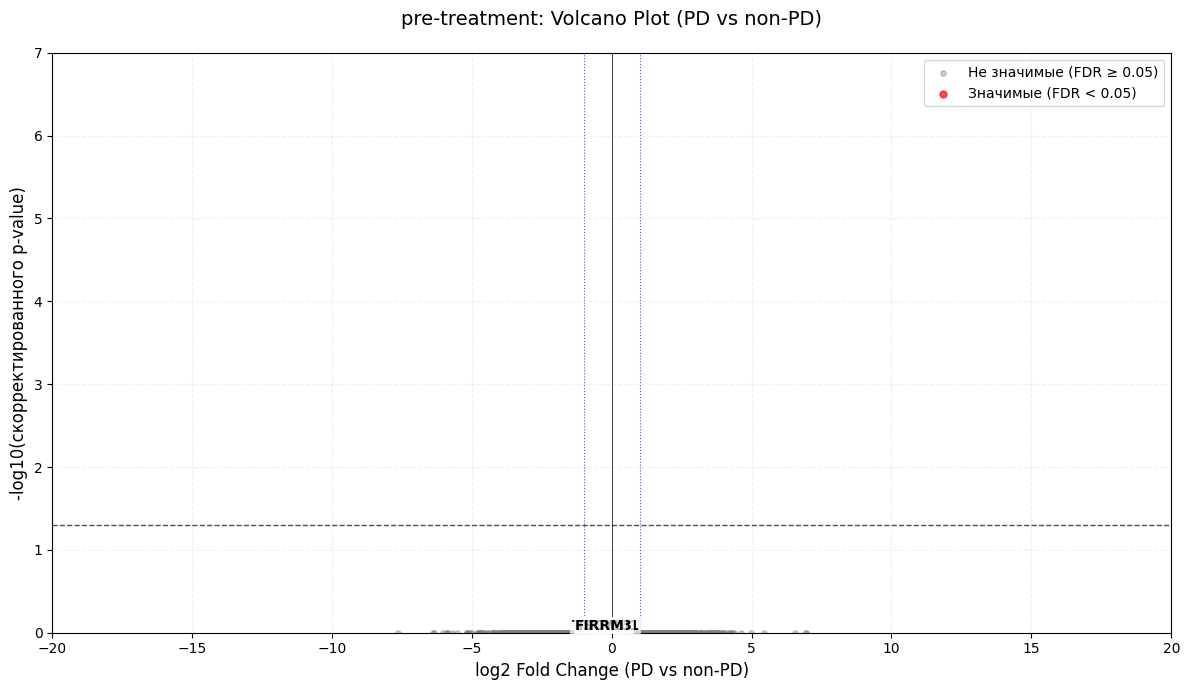

Index(['C8B', 'ITIH1', 'CFHR2', 'APOB', 'TF', 'AMBP', 'C9', 'HRG', 'SERPINC1',
       'TTR', 'PLG', 'LBP', 'CYP2E1', 'G6PC1', 'EGF', 'SLC13A5', 'GC', 'DRD2',
       'ITIH2', 'APOA2', 'SLC2A2', 'ALB', 'FGG', 'FGA', 'FGB', 'AGXT', 'F2',
       'HP'],
      dtype='object')


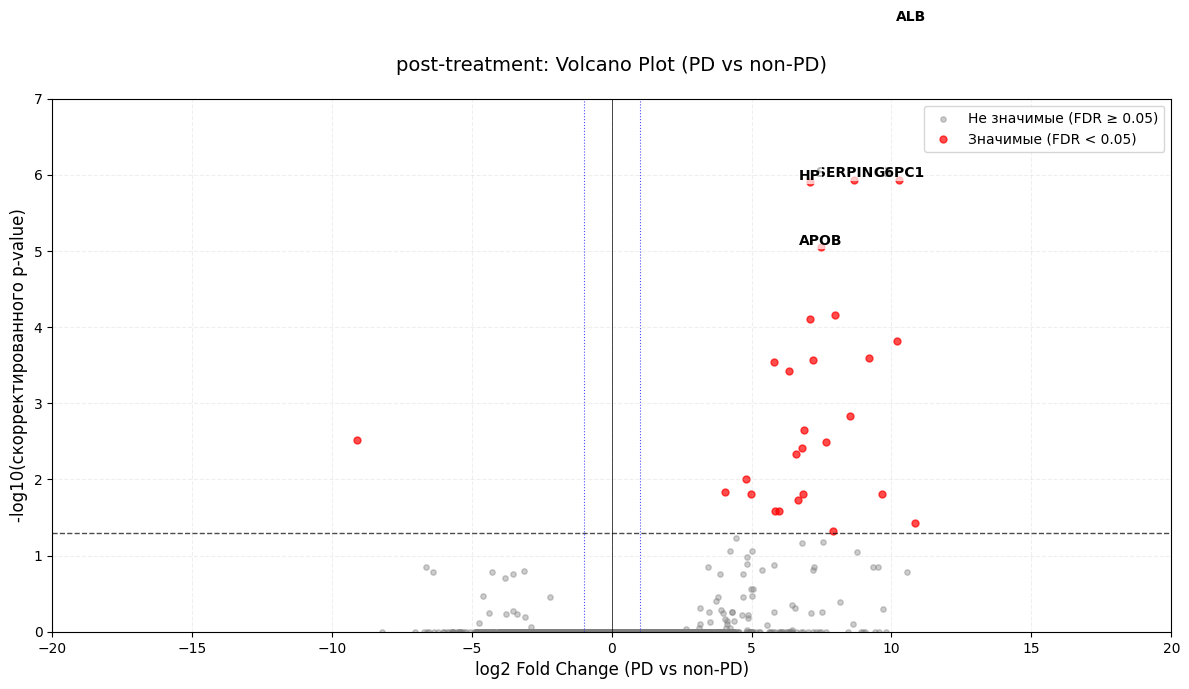

In [15]:
import matplotlib.pyplot as plt

def volcanoplot(results, name):  
    # Настройка стиля
    plt.style.use('default')  # Современный стиль
    plt.figure(figsize=(12, 7))
    
    # Данные
    log2fc = results['log2FoldChange']
    neg_log_padj = -np.log10(results['padj'])
    significant = results['padj'] < 0.05
    print(results.index[significant])
    
    # Цвета и размер точек
    plt.scatter(log2fc[~significant], neg_log_padj[~significant], 
                color='gray', alpha=0.4, s=15, label='Не значимые (FDR ≥ 0.05)')
    plt.scatter(log2fc[significant], neg_log_padj[significant], 
                color='red', alpha=0.7, s=25, label='Значимые (FDR < 0.05)')
    
    # Подписи топ-5 генов (по значимости)
    top_genes = results.nsmallest(5, 'padj')
    for gene in top_genes.index:
        idx = results.index.get_loc(gene)
        plt.text(log2fc[idx], neg_log_padj[idx], gene, 
                 fontsize=10, ha='center', va='bottom', fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    # Референсные линии
    plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.axvline(1, color='blue', linestyle=':', linewidth=0.8, alpha=0.7)
    plt.axvline(-1, color='blue', linestyle=':', linewidth=0.8, alpha=0.7)
    
    plt.xlim(-20, 20)
    plt.ylim(0, 7)
    
    # Подписи и легенда
    plt.xlabel('log2 Fold Change (PD vs non-PD)', fontsize=12)
    plt.ylabel('-log10(скорректированного p-value)', fontsize=12)
    plt.title(f'{name}: Volcano Plot (PD vs non-PD)', fontsize=14, pad=20)
    plt.legend(frameon=True, loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()

volcanoplot(deseq_results['pre'], 'pre-treatment')
volcanoplot(deseq_results['post'], 'post-treatment')

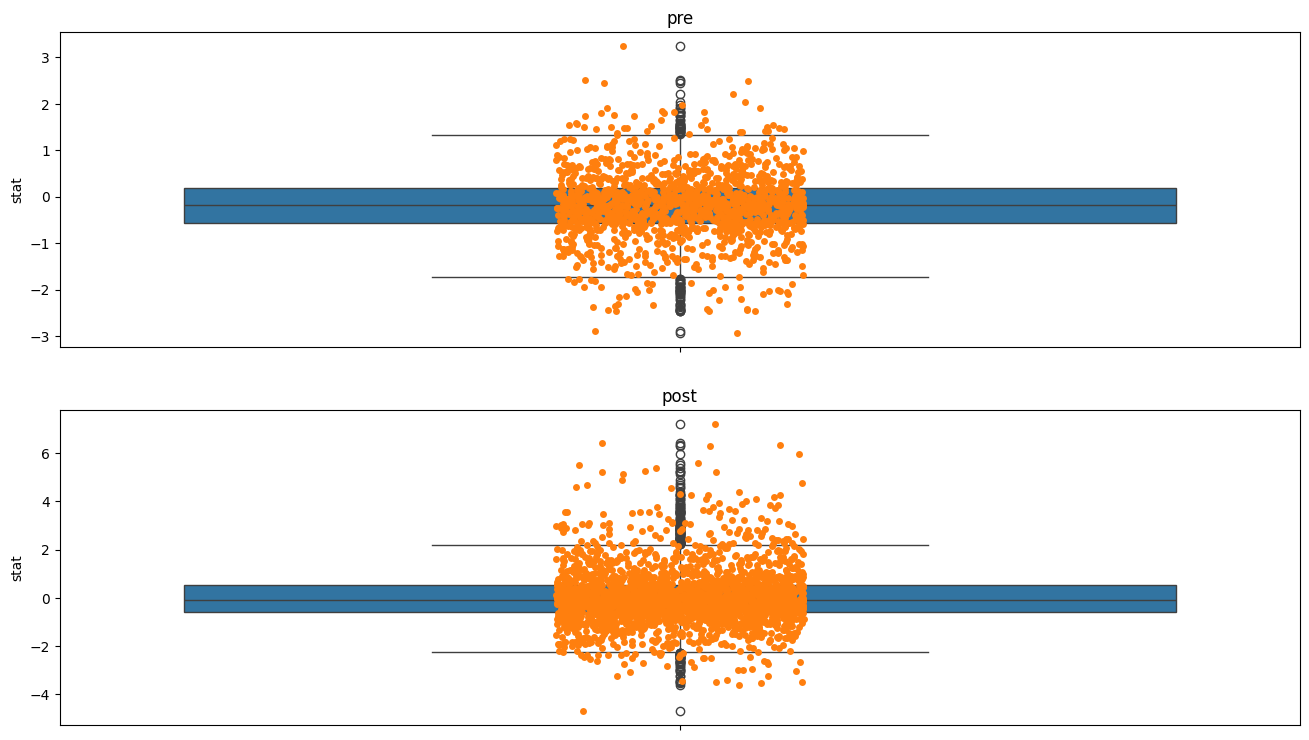

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16, 9))

for i, group in enumerate(deseq_results):
    res = deseq_results[group]
    x = res.loc[np.abs(res['log2FoldChange']) > 1]['stat']
    sns.boxplot(x, ax=axs[i])
    sns.stripplot(x, ax=axs[i])
    axs[i].set_title(group)